In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2, mutual_info_classif
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"

In [2]:
def generate_model(hidden_layers, neurons, dropout, optimizer, L2, n_bits):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_bits, activation='relu', input_shape=(n_bits,)),tf.keras.layers.Dropout(dropout)]+
        [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    return model

def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return mcc

def features_correlation(features):
    k = features.shape[1]
    corr = np.zeros((k, k))
    for i in range(k):
        corr_vals, _ = chi2(features, features[:, i])
        corr[i, :] = corr_vals
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(corr, annot=False, ax = ax, cmap="Greens", mask=np.eye(k))
    plt.show()
    
def features_correlation_mutual_info(features):
    k = features.shape[1]
    corr = np.zeros((k, k))
    for i in range(k):
        corr_vals = mutual_info_classif(features, features[:, i])
        corr[i, :] = corr_vals
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(corr, annot=False, ax = ax, cmap="Greens", mask=np.eye(k))
    plt.show()

In [3]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

features_shared = np.load(os.path.join("features", "shared_set_features_MACCS.npy"))
features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features_MACCS.npy"))
features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features_MACCS.npy"))

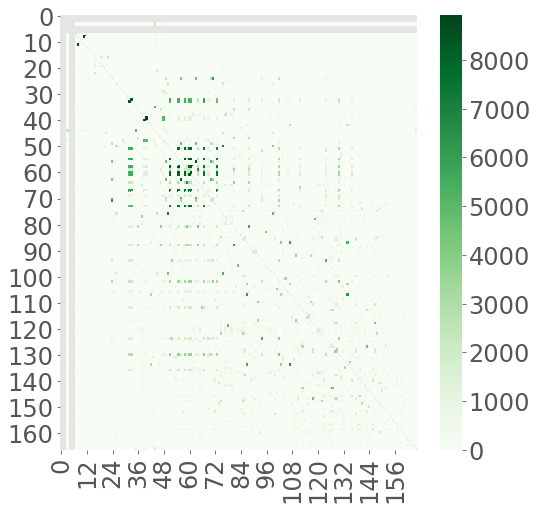

In [4]:
features_correlation(features_shared)

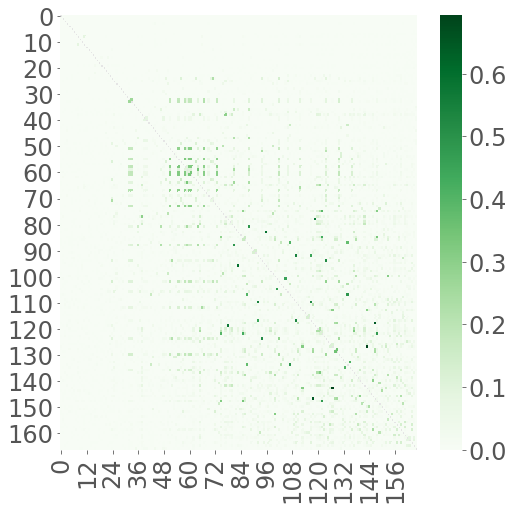

In [5]:
features_correlation_mutual_info(features_shared)

In [6]:
feat_select = SelectPercentile(chi2, percentile=10)
shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
only_2c9_reduced = feat_select.transform(features_only_2c9)
only_3a4_reduced = feat_select.transform(features_only_3a4)

threshold = 0.9
# sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
# features_shared = sel.fit_transform(features_shared)
# features_only_2c9 = sel.transform(features_only_2c9)
# features_only_3a4 = sel.transform(features_only_3a4)

combined_filters = VarianceThreshold(threshold * (1 - threshold))
shared_reduced_comb = combined_filters.fit_transform(shared_reduced)
only_2c9_reduced_comb = combined_filters.transform(only_2c9_reduced)
only_3a4_reduced_comb = combined_filters.transform(only_3a4_reduced)

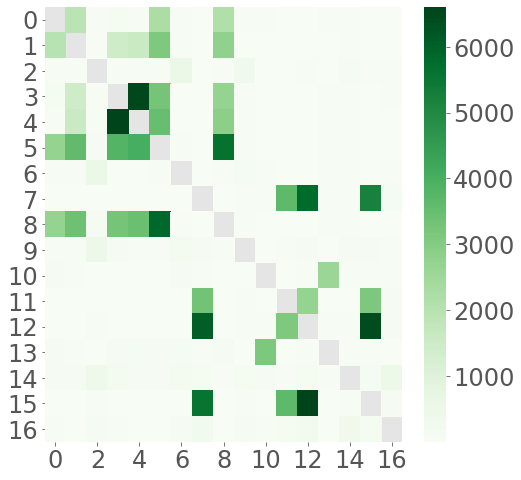

In [7]:
features_correlation(shared_reduced)

We try selecting the top features, moving the percentile value

In [8]:
hidden_layers = 4
neurons = 150
dropout = 0.2
lr = 0.001
opt  = tf.keras.optimizers.Adam(lr=lr)
L2 = 0.001
percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    n_features.append(N_BITS)
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 5 percentile, 9 features
NER: 0.617, Sensitivity or recall: 0.303, Specificity: 0.931, Precision: 0.676, Correctly calssified: 0.729, MCC: 0.311
Testing
NER: 0.572, Sensitivity or recall: 0.239, Specificity: 0.905, Precision: 0.588, Correctly calssified: 0.665, MCC: 0.196
Validation set with 10 percentile, 17 features
NER: 0.588, Sensitivity or recall: 0.215, Specificity: 0.961, Precision: 0.721, Correctly calssified: 0.721, MCC: 0.279
Testing
NER: 0.553, Sensitivity or recall: 0.156, Specificity: 0.950, Precision: 0.641, Correctly calssified: 0.664, MCC: 0.181
Validation set with 15 percentile, 25 features
NER: 0.662, Sensitivity or recall: 0.403, Specificity: 0.921, Precision: 0.708, Correctly calssified: 0.755, MCC: 0.391
Testing
NER: 0.608, Sensitivity or recall: 0.337, Specificity: 0.880, Precision: 0.613, Correctly calssified: 0.684, MCC: 0.261
Validation set with 20 percentile, 34 features
NER: 0.676, Sensitivity or recall: 0.431, Specificity: 0.922, Precisio

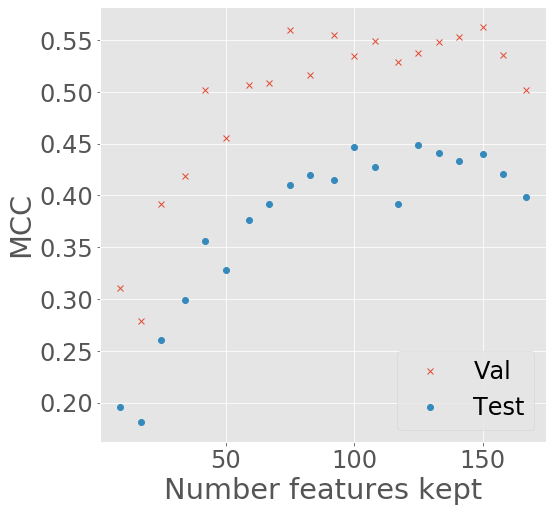

In [9]:
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 9 features
NER: 0.617, Sensitivity or recall: 0.341, Specificity: 0.894, Precision: 0.603, Correctly calssified: 0.716, MCC: 0.284
Testing
NER: 0.592, Sensitivity or recall: 0.299, Specificity: 0.885, Precision: 0.596, Correctly calssified: 0.674, MCC: 0.230
Validation set with 10 percentile, 17 features
NER: 0.650, Sensitivity or recall: 0.441, Specificity: 0.859, Precision: 0.597, Correctly calssified: 0.725, MCC: 0.330
Testing
NER: 0.622, Sensitivity or recall: 0.435, Specificity: 0.809, Precision: 0.562, Correctly calssified: 0.674, MCC: 0.261
Validation set with 15 percentile, 25 features
NER: 0.697, Sensitivity or recall: 0.524, Specificity: 0.869, Precision: 0.655, Correctly calssified: 0.758, MCC: 0.421
Testing
NER: 0.634, Sensitivity or recall: 0.455, Specificity: 0.813, Precision: 0.579, Correctly calssified: 0.684, MCC: 0.285
Validation set with 20 percentile, 34 features
NER: 0.735, Sensitivity or recall: 0.625, Specificity: 0.846, Precisio

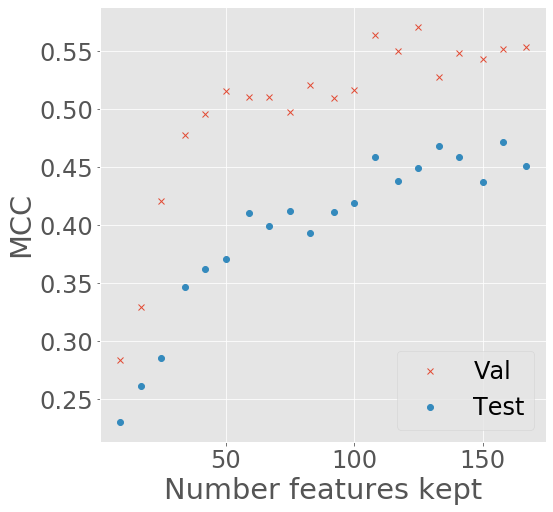

In [10]:
percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    n_features.append(N_BITS)
    model = SVC(C=8, kernel="rbf")
    model.fit(train_data, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 9 features
Testing
Validation set with 10 percentile, 17 features
Testing
Validation set with 15 percentile, 25 features
Testing
Validation set with 20 percentile, 34 features
Testing
Validation set with 25 percentile, 42 features
Testing
Validation set with 30 percentile, 50 features
Testing
Validation set with 35 percentile, 59 features
Testing
Validation set with 40 percentile, 67 features
Testing
Validation set with 45 percentile, 75 features
Testing
Validation set with 50 percentile, 83 features
Testing
Validation set with 55 percentile, 92 features
Testing
Validation set with 60 percentile, 100 features
Testing
Validation set with 65 percentile, 108 features
Testing
Validation set with 70 percentile, 117 features
Testing
Validation set with 75 percentile, 125 features
Testing
Validation set with 80 percentile, 133 features
Testing
Validation set with 85 percentile, 141 features
Testing
Validation set with 90 percentile, 150 features
Testing
Valid

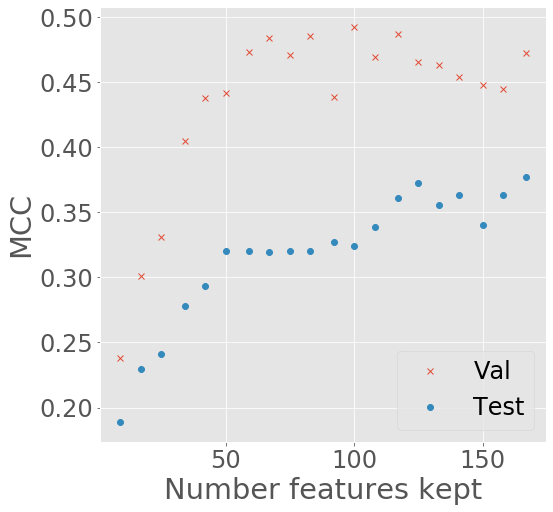

In [11]:
from sklearn.neighbors import KNeighborsClassifier

percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    n_features.append(N_BITS)
    model = KNeighborsClassifier()
    model.fit(train_data, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels, verbose=False))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9, verbose=False))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Validation set with 5 percentile, 9 features
Testing
Validation set with 10 percentile, 17 features
Testing
Validation set with 15 percentile, 25 features
Testing
Validation set with 20 percentile, 34 features
Testing
Validation set with 25 percentile, 42 features
Testing
Validation set with 30 percentile, 50 features
Testing
Validation set with 35 percentile, 59 features
Testing
Validation set with 40 percentile, 67 features
Testing
Validation set with 45 percentile, 75 features
Testing
Validation set with 50 percentile, 83 features
Testing
Validation set with 55 percentile, 92 features
Testing
Validation set with 60 percentile, 100 features
Testing
Validation set with 65 percentile, 108 features
Testing
Validation set with 70 percentile, 117 features
Testing
Validation set with 75 percentile, 125 features
Testing
Validation set with 80 percentile, 133 features
Testing
Validation set with 85 percentile, 141 features
Testing
Validation set with 90 percentile, 150 features
Testing
Valid

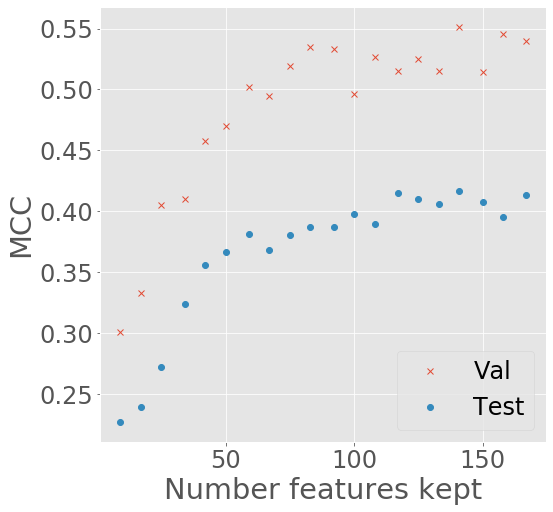

In [12]:
from sklearn.ensemble import RandomForestClassifier

percentiles = list(range(5,101,5))
n_features = []
MCCs = []
MCC_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    n_features.append(N_BITS)
    model = RandomForestClassifier()
    model.fit(train_data, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels, verbose=False))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9, verbose=False))
    
plt.figure(figsize=(8,8))
plt.plot(n_features, MCCs, 'x', label="Val")
plt.plot(n_features, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Number features kept")
plt.legend()

Now we filter features according to variance, given that the input is binary, we use the variance formula for the Bernouilli probability distribution v=p*(1-p)

In [13]:
percentiles = [0.1*i for i in range(1, 10)]
MCCs = []
MCC_test = []
for percentile in percentiles:
    sel = VarianceThreshold(threshold=(percentile * (1 - percentile)))
    try:
        shared_reduced = sel.fit_transform(features_shared)
    except ValueError:
        MCCs.append(np.nan)
        MCC_test.append(np.nan)
        continue
    only_2c9_reduced = sel.transform(features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 0.1 percentile, 106 features
NER: 0.720, Sensitivity or recall: 0.571, Specificity: 0.870, Precision: 0.675, Correctly calssified: 0.774, MCC: 0.462
Testing
NER: 0.705, Sensitivity or recall: 0.575, Specificity: 0.836, Precision: 0.664, Correctly calssified: 0.742, MCC: 0.426
Validation set with 0.2 percentile, 82 features
NER: 0.771, Sensitivity or recall: 0.684, Specificity: 0.857, Precision: 0.694, Correctly calssified: 0.802, MCC: 0.544
Testing
NER: 0.701, Sensitivity or recall: 0.609, Specificity: 0.794, Precision: 0.625, Correctly calssified: 0.727, MCC: 0.405
Validation set with 0.30000000000000004 percentile, 57 features
NER: 0.710, Sensitivity or recall: 0.551, Specificity: 0.869, Precision: 0.666, Correctly calssified: 0.767, MCC: 0.444
Testing
NER: 0.667, Sensitivity or recall: 0.478, Specificity: 0.856, Precision: 0.653, Correctly calssified: 0.720, MCC: 0.365
Validation set with 0.4 percentile, 36 features
NER: 0.673, Sensitivity or recall: 0.534, Speci

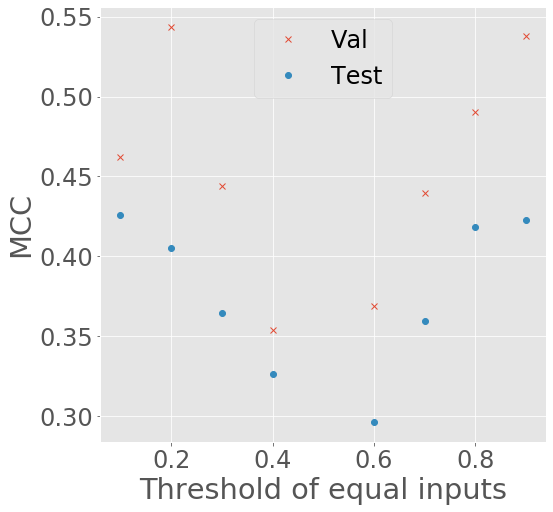

In [14]:
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Threshold of equal inputs")
plt.legend(loc="upper center")

We now combine the two feature selectors, setting the variance one at threshold 0.1

In [15]:
percentiles = list(range(5,101,5))
MCCs = []
MCC_test = []
sel = VarianceThreshold(threshold=(0.1 * (1 - 0.1)))
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    shared_reduced = sel.fit_transform(shared_reduced)
    only_2c9_reduced = sel.transform(only_2c9_reduced)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
    model.fit(train_data, train_labels, epochs=10, verbose=0)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = model.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = model.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))

Validation set with 5 percentile, 9 features
NER: 0.590, Sensitivity or recall: 0.267, Specificity: 0.913, Precision: 0.592, Correctly calssified: 0.705, MCC: 0.239
Testing
NER: 0.571, Sensitivity or recall: 0.239, Specificity: 0.903, Precision: 0.583, Correctly calssified: 0.663, MCC: 0.192
Validation set with 10 percentile, 17 features
NER: 0.619, Sensitivity or recall: 0.341, Specificity: 0.897, Precision: 0.611, Correctly calssified: 0.718, MCC: 0.290
Testing
NER: 0.606, Sensitivity or recall: 0.330, Specificity: 0.883, Precision: 0.614, Correctly calssified: 0.683, MCC: 0.258
Validation set with 15 percentile, 25 features
NER: 0.665, Sensitivity or recall: 0.445, Specificity: 0.885, Precision: 0.647, Correctly calssified: 0.744, MCC: 0.371
Testing
NER: 0.632, Sensitivity or recall: 0.412, Specificity: 0.851, Precision: 0.610, Correctly calssified: 0.692, MCC: 0.294
Validation set with 20 percentile, 31 features
NER: 0.720, Sensitivity or recall: 0.584, Specificity: 0.857, Precisio

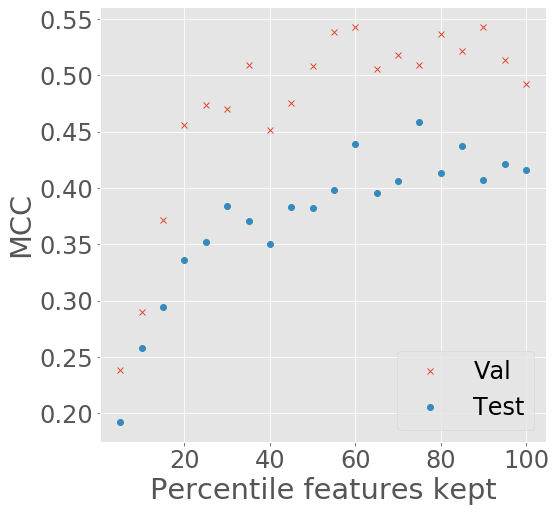

In [16]:
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Percentile features kept")
plt.legend()

We repeat the same with a SVM model

Validation set with 5 percentile, 9 features
NER: 0.612, Sensitivity or recall: 0.301, Specificity: 0.924, Precision: 0.651, Correctly calssified: 0.724, MCC: 0.295
Testing
NER: 0.575, Sensitivity or recall: 0.250, Specificity: 0.901, Precision: 0.588, Correctly calssified: 0.666, MCC: 0.201
Validation set with 10 percentile, 17 features
NER: 0.656, Sensitivity or recall: 0.460, Specificity: 0.853, Precision: 0.597, Correctly calssified: 0.727, MCC: 0.338
Testing
NER: 0.633, Sensitivity or recall: 0.457, Specificity: 0.810, Precision: 0.576, Correctly calssified: 0.683, MCC: 0.284
Validation set with 15 percentile, 25 features
NER: 0.689, Sensitivity or recall: 0.509, Specificity: 0.869, Precision: 0.648, Correctly calssified: 0.753, MCC: 0.406
Testing
NER: 0.645, Sensitivity or recall: 0.458, Specificity: 0.832, Precision: 0.607, Correctly calssified: 0.697, MCC: 0.313
Validation set with 20 percentile, 31 features
NER: 0.733, Sensitivity or recall: 0.589, Specificity: 0.877, Precisio

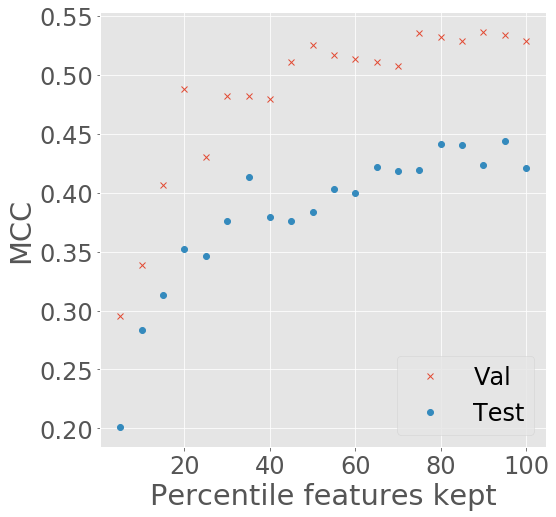

In [17]:
percentiles = list(range(5,101,5))
MCCs = []
MCC_test = []
sel = VarianceThreshold(threshold=(0.1 * (1 - 0.1)))
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(features_shared, labels_2c9)
    only_2c9_reduced = feat_select.transform(features_only_2c9)
    shared_reduced = sel.fit_transform(shared_reduced)
    only_2c9_reduced = sel.transform(only_2c9_reduced)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    N_BITS = train_data.shape[1]
    svm = SVC(C=8, kernel="rbf")
    svm.fit(train_data, train_labels)
    print(f"Validation set with {percentile} percentile, {N_BITS} features")
    predictions = svm.predict(val_data)
    MCCs.append(print_metrics(predictions, val_labels))
    print("Testing")
    predictions = svm.predict(only_2c9_reduced)
    MCC_test.append(print_metrics(predictions, labels_testing_2c9))
    
plt.figure(figsize=(8,8))
plt.plot(percentiles, MCCs, 'x', label="Val")
plt.plot(percentiles, MCC_test, 'o', label="Test")
plt.ylabel("MCC")
plt.xlabel("Percentile features kept")
plt.legend()

In [18]:
print(features_shared.shape, features_only_2c9.shape, features_only_3a4.shape)
print(shared_reduced.shape, only_2c9_reduced.shape, only_3a4_reduced.shape)
print(shared_reduced_comb.shape, only_2c9_reduced_comb.shape, only_3a4_reduced_comb.shape)

(9420, 167) (2813, 167) (2994, 167)
(9420, 106) (2813, 106) (2994, 17)
(9420, 17) (2813, 17) (2994, 17)


In [19]:
train_data, val_data, train_labels, val_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9)
N_BITS = train_data.shape[1]

In [20]:
hidden_layers = 4
neurons = 150
dropout = 0.2
lr = 0.001
opt  = tf.keras.optimizers.Adam(lr=lr)
L2 = 0.001

model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(features_only_2c9)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.8113 - binary_accuracy: 0.7393
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5649 - binary_accuracy: 0.7813
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4933 - binary_accuracy: 0.8007
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4643 - binary_accuracy: 0.8030
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4309 - binary_accuracy: 0.8218
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4086 - binary_accuracy: 0.8314
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.3928 - binary_accuracy: 0.8396
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 0.3758 - binary_accuracy: 0.8505
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.3570 - binary_accuracy: 0.8577
Epoch 10/10
221/221 [================

Try the same NN with another feature selection method

In [21]:
# print(shared_reduced.shape, only_2c9_reduced.shape, only_3a4_reduced.shape)
train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
N_BITS = train_data.shape[1]

In [22]:
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(only_2c9_reduced)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6297 - binary_accuracy: 0.7069
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4936 - binary_accuracy: 0.7666
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4662 - binary_accuracy: 0.7850
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4470 - binary_accuracy: 0.7977
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4292 - binary_accuracy: 0.8082
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4176 - binary_accuracy: 0.8194
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4074 - binary_accuracy: 0.8232
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.3998 - binary_accuracy: 0.8290
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.3845 - binary_accuracy: 0.8389
Epoch 10/10
221/221 [================

In [23]:
# print(shared_reduced_comb.shape, only_2c9_reduced_comb.shape, only_3a4_reduced_comb.shape)
train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced_comb, labels_2c9, stratify=labels_2c9)
N_BITS = train_data.shape[1]

In [25]:
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.fit(train_data, train_labels, epochs=10)
print("Validation set")
predictions = model.predict(val_data)
print_metrics(predictions, val_labels)
print("Test set")
predictions = model.predict(only_2c9_reduced_comb)
print_metrics(predictions, labels_testing_2c9);

Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6212 - binary_accuracy: 0.6979
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5519 - binary_accuracy: 0.7134
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5422 - binary_accuracy: 0.7183
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5380 - binary_accuracy: 0.7156
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5348 - binary_accuracy: 0.7210
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5291 - binary_accuracy: 0.7250
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5278 - binary_accuracy: 0.7284
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5309 - binary_accuracy: 0.7274
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5260 - binary_accuracy: 0.7271
Epoch 10/10
221/221 [================

In [27]:
kernel = "rbf"
C_values = np.geomspace(0.1, 100, num=20)
for c in C_values:
    svm = SVC(C=c, kernel=kernel)
    svm.fit(train_data, train_labels)
    predicted = svm.predict(val_data)
    print(f"Scores using C={c} for validation")
    print_metrics(predicted, val_labels)
    predictions = svm.predict(only_2c9_reduced_comb)
    print("  Scores for testing")
    print_metrics(predictions, labels_testing_2c9);

Scores using C=0.1 for validation
NER: 0.627, Sensitivity or recall: 0.339, Specificity: 0.914, Precision: 0.651, Correctly calssified: 0.729, MCC: 0.316
  Scores for testing
NER: 0.583, Sensitivity or recall: 0.282, Specificity: 0.884, Precision: 0.580, Correctly calssified: 0.667, MCC: 0.210
Scores using C=0.14384498882876628 for validation
NER: 0.631, Sensitivity or recall: 0.350, Specificity: 0.911, Precision: 0.651, Correctly calssified: 0.731, MCC: 0.323
  Scores for testing
NER: 0.586, Sensitivity or recall: 0.287, Specificity: 0.884, Precision: 0.584, Correctly calssified: 0.669, MCC: 0.216
Scores using C=0.20691380811147897 for validation
NER: 0.643, Sensitivity or recall: 0.394, Specificity: 0.892, Precision: 0.634, Correctly calssified: 0.732, MCC: 0.334
  Scores for testing
NER: 0.612, Sensitivity or recall: 0.362, Specificity: 0.861, Precision: 0.595, Correctly calssified: 0.681, MCC: 0.259
Scores using C=0.29763514416313175 for validation
NER: 0.652, Sensitivity or recall